# Data Fetching and Preparation

You can get the data here: 
wget https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz && tar xvzf cooking.stackexchange.tar.gz


In [45]:
# init
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
import pandas as pd
from pathlib import Path

FN1='converted.csv'
FN2='jrc_en_preprocessed_text.csv'

bs = 32

In [ ]:
while True:
    import time
    time.sleep(1)

**Get the dataset**





In [9]:
df_conv = pd.read_csv(FN1)
df_conv.head(2)

,Unnamed: 0,text,labels
0,0,[ pic ] | COMMISSION OF THE EUROPEAN COMMUNITI...,100175;100237;100238;100240
1,1,DIRECTIVE 96 / 71 / EC OF THE EUROPEAN PARLIAM...,100227;100233;100234;100236


In [8]:
df_prep = pd.read_csv(FN2, delimiter=';')
df_prep.head(2)

,docid,text
0,jrc51976FC0135-en,commission community com proposal <legalact> p...
1,jrc31996L0071-en,parliament council <date> concern post worker ...


In [11]:
# combine to two df

FN = 'converted_prep.csv'

df = pd.concat([df_prep.text, df_conv.labels], axis=1)
print(df.head())

df.to_csv(FN)




                                                text  \
0  commission community com proposal <legalact> p...   
1  parliament council <date> concern post worker ...   
2  commission <legalact> <date> council <legalact...   
3  commission decision <date> condition import fi...   
4  commission decision <date> condition import fi...   

                                      labels  
0                100175;100237;100238;100240  
1                100227;100233;100234;100236  
2                       100215;100244;100254  
3  100192;100193;100252;100279;100282;100283  
4         100192;100193;100252;100280;100282  


In [12]:
df.head()

,text,labels
0,commission community com proposal <legalact> p...,100175;100237;100238;100240
1,parliament council <date> concern post worker ...,100227;100233;100234;100236
2,commission <legalact> <date> council <legalact...,100215;100244;100254
3,commission decision <date> condition import fi...,100192;100193;100252;100279;100282;100283
4,commission decision <date> condition import fi...,100192;100193;100252;100280;100282


## Reuse Fine-tuned of the language model from "JRC_basic" folder


In [46]:
data_lm = load_data(Path('.'), 'data_lm_prep.pkl', bs=bs)

/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [16]:
data_lm.show_batch()

idx,text
0,community procedure change substance instrument codification parliament council commission agreement date < date > procedure adoption codification instrument purpose proposal codification < legalact > < date > recognition navigability licence inland < legalact > act incorporate proposal content act hence bring amendment require codification exercise codification proposal basis consolidation official language < legalact > instrument office official publication community system number correlation number show contain codify < legalact > proposal
1,grant typeapproval measure accordance verify arrangement production vehicle system unit type whereas govern control conformity production carry approval authority harmonise order application interpretation guidance procedure whereas measure accordance opinion committee adaptation progress adopt < legalact > < reference><legalact > < reference > application vehicle manufacturer approval authority member state application information folder contain information approval certificate < legalact > require xi information package system unit approval respect < legalact >
2,< reference > romania austria agreement – < reference > romania belgium agreement – < reference > romania cyprus agreement – < reference > romania czech agreement – < reference > romania denmark agreement – < reference > romania finland agreement – < reference > romania france agreement – < reference > – agreement < reference > romania greece agreement – < reference > romania hungary – agreement < reference
3,date transaction ie < date > book value < date > base market value company amount base information aesa eur company eur – gain conclusion payment eur company cadiz juliana manis accordance market investor principle gain therefore consider state aid aesa sale shipyard company ship construction state aid commission market authorise restructuring aid type aid report company state continuation operation support shareholder ie sepi aesa information commission conclude aid transaction
4,"role promote right union help people exercise action commitment entity member state support society promote dialogue see fight discrimination peace way programme justice “ "" action fight racism xenophobia antisemitism promotion dialogue eu level support society respect enlarge cover member state action member state focus derive citizenship union recognise charter participation increase envelope plan increase importance issue respond society actor programme indicatordefinition promote development society base union citizenship enshrine charter"


## Train a classifier

As we are using multi-label classification, we define our own metrics (fastai doesn't support multi-label well yet)

In [47]:
def my_prc(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()
  
def my_rec(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))

thresh=0.001
acc_0001 = partial(accuracy_thresh, thresh=thresh)
prc_0001 = partial(my_prc, thresh=thresh)
rec_0001 = partial(my_rec, thresh=thresh)
f_0001 = partial(fbeta, thresh=thresh, beta=1)


thresh=0.01
acc_001 = partial(accuracy_thresh, thresh=thresh)
prc_001 = partial(my_prc, thresh=thresh)
rec_001 = partial(my_rec, thresh=thresh)
f_001 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.05
acc_005 = partial(accuracy_thresh, thresh=thresh)
prc_005 = partial(my_prc, thresh=thresh)
rec_005 = partial(my_rec, thresh=thresh)
f_005 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.1
acc_01 = partial(accuracy_thresh, thresh=thresh)
prc_01 = partial(my_prc, thresh=thresh)
rec_01 = partial(my_rec, thresh=thresh)
f_01 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
prc_02 = partial(my_prc, thresh=thresh)
rec_02 = partial(my_rec, thresh=thresh)
f_02 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.3
acc_03 = partial(accuracy_thresh, thresh=thresh)
prc_03 = partial(my_prc, thresh=thresh)
rec_03 = partial(my_rec, thresh=thresh)
f_03 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.4
acc_04 = partial(accuracy_thresh, thresh=thresh)
prc_04 = partial(my_prc, thresh=thresh)
rec_04 = partial(my_rec, thresh=thresh)
f_04 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.5
acc_05 = partial(accuracy_thresh, thresh=thresh)
prc_05 = partial(my_prc, thresh=thresh)
rec_05 = partial(my_rec, thresh=thresh)
f_05 = partial(fbeta, thresh=thresh, beta=1)


In [18]:
print(FN)

converted_prep.csv


In [19]:
data_clas = (TextList.from_csv(Path('.'), FN, vocab=data_lm.vocab, cols='text')
             #grab all the text files in path
             #wohlg: .split_by_folder(valid='test')
             .split_by_rand_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)             
             #wohlg: .label_from_folder(classes=['neg', 'pos'])
             .label_from_df(cols='labels', label_delim=';')
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas_prep.pkl')

In [20]:
print(len(data_lm.vocab.itos))
print(data_lm.vocab.itos[:20])

60000
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '>', '<', 'date', 'legalact', 'reference', 'state', 'commission', 'member', 'community', 'product', 'council']


In [48]:
data_clas = load_data(Path('.'), 'data_clas_prep.pkl', bs=bs)

In [22]:
data_clas.show_batch()

text,target
xxbos section commission content volume section commission title surplus title revenue person work institution community body revenue operation institution title contribution refund connection community agreement programme interest payment title borrow lending operation revenue title xx expenditure allocate policy area chapter xx expenditure allocate policy area title affair chapter expenditure affair policy area chapter union chapter affair chapter operation instrument title enterprise chapter expenditure enterprise policy area chapter policy innovation chapter,100177;100205
xxbos position council < date > view < legalact > parliament council requirement inland repeal parliament council union regard treaty community < reference > thereof regard proposal commission opinion committee consultation committee region act accordance procedure < reference > treaty whereas lay requirement inland condition issue certificate inland member state exclude operation rhine level requirement inland waterway vessel coexistence < legalact > obstruct effort recognition navigation certificate inspection vessel contain,100237;100240;100261
xxbos commission community < date > proposal parliament council classification product activity council < legalact > ° memorandum context proposal ground proposal classification product activity cpa harmonisation classification activity revise version cpa take account development economy year revision nace classification product context amendment cpa introduce adoption issue revise version prompt change place economy revision classification activity product result revise cpa reality classification provision area cover proposal < legalact > °,100190;100192;100195;100220
xxbos xxunk decision < date > concern specification interoperability relate subsystem speed rail system concern specification interoperability relate subsystem rail system commission community treaty community < legalact > < date > interoperability traneuropean rail system < reference > thereof regard < legalact > parliament council interoperability rail system < reference > thereof whereas accordance < reference > < legalact > speed rail system subsystem control subsystem < legalact > specification,100176;100237;100238;100239;100261
xxbos state aid belgium state aid inter boat invitation submit comment pursuant < reference > ec treaty letter date < date > language page commission belgium decision initiate procedure < reference > ec treaty abovementione aid measure party comment aid measure commission initiate procedure month date publication letter commission transport energy directorate affair resource office brussel comment communicate belgium treatment identity party comment state reason request text procedure case description,100185;100222;100231;100238;100239;100277;100282;100283


In [49]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, wd=0.1)
#learn.metrics = [accuracy_thresh, custom_precision, custom_recall, 
#                 acc_01, f_score_01, acc_02, f_score_02, acc_03, f_score_03 ]
learn.metrics = [accuracy_thresh, 
                 acc_0001, prc_0001, rec_0001, f_0001,
                 acc_001, prc_001, rec_001, f_001,
                 acc_005, prc_005, rec_005, f_005,
                 acc_01, prc_01, rec_01, f_01,
                 acc_02, prc_02, rec_02, f_02,
                 acc_03, prc_03, rec_03, f_03,
                 acc_04, prc_04, rec_04, f_04,
                 acc_05, prc_05, rec_05, f_05 ]
#!mv *pth models
learn.load_encoder('fine_tuned_enc-JRC_prep')


In [24]:
print(learn.loss_func)
print(learn.loss_func.func)

FlattenedLoss of BCEWithLogitsLoss()
BCEWithLogitsLoss()


In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


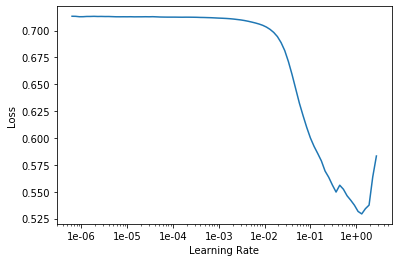

In [26]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(2, slice(1e-1,1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.099264,0.092035,0.970302,0.436324,0.694707,0.343742,0.117098,0.773179,0.695399,0.341536,0.233083,0.907247,0.700855,0.334879,0.375985,0.939256,0.708168,0.327248,0.444278,0.959002,0.720405,0.312157,0.480853,0.965952,0.733751,0.298329,0.472411,0.969425,0.747157,0.282804,0.456498,0.970302,0.757646,0.268211,0.415479,04:28
1,0.080597,0.071066,0.975325,0.374366,0.783283,0.452890,0.107742,0.750409,0.784973,0.451749,0.233120,0.911466,0.790674,0.444704,0.437254,0.946832,0.796761,0.436368,0.532236,0.967459,0.810914,0.421099,0.606400,0.973041,0.820433,0.402538,0.607312,0.974974,0.833156,0.385197,0.586310,0.975325,0.843303,0.367814,0.547374,04:29


## Results:

### no prep:

    learn.fit_one_cycle(1, slice(1e-2,1e-1), moms=(0.8,0.7)): 

    first: 0	0.126340	0.128604	0.959962	0.134139	0.415983	0.196693	0.078071
           1	0.111104	0.102011	0.968039	0.195334	0.700530	0.198081	0.082793	
    last: 0.959962	0.473046	0.131962	0.220850	18:46
          0.968039	0.787151	0.137742	0.264398	18:52   
   

In [29]:
learn.save('first_prep')

In [30]:
learn.load('first_prep')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (14016 items)
x: TextList
xxbos commission community com proposal < legalact > parliament council recognition navigability licence inland memorandum context people commission attach importance simplify community law clearer citizen opportunity chance use aim provision time instrument research work instrument rule reason codification rule community law transparent < date > commission instruct staff act amendment stress requirement department endeavour interval text community rule conclusion presidency council stress importance codification certainty law matter time codification compliance community procedure change substance instrument codification parliament council commission agreement date < date > procedure adoption codification instrument purpose proposal codification < legalact > < date > recognition navigability licence inland < legalact > act incorporate proposal content act hence bring amendment require codification exercise 

Why gradual unfreeze? Give example of Image detection.

In [31]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


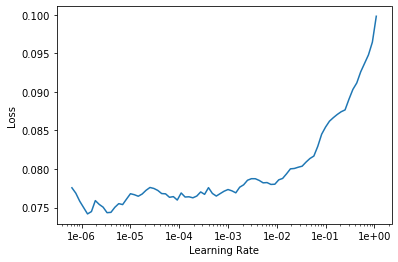

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
# learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.fit_one_cycle(2, slice(8e-3/(2.6**4),8e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.076004,0.068571,0.976077,0.375970,0.793721,0.473166,0.108020,0.744344,0.794913,0.471823,0.233503,0.910793,0.799861,0.465540,0.455642,0.947728,0.806629,0.457512,0.558098,0.968172,0.819276,0.440733,0.628088,0.974142,0.830011,0.426268,0.635115,0.975873,0.840468,0.410699,0.610418,0.976077,0.853418,0.395524,0.572528,04:39
1,0.067528,0.062717,0.977962,0.465640,0.801768,0.532878,0.125709,0.793954,0.802764,0.531892,0.277358,0.926267,0.806986,0.525633,0.506862,0.954710,0.813008,0.518617,0.596839,0.971063,0.825264,0.502731,0.658701,0.975855,0.834021,0.488426,0.664473,0.977568,0.844154,0.474156,0.649095,0.977962,0.854261,0.460019,0.620971,04:45


### Results:
    
### no prep:
    first:
    0	0.102726	0.092592	0.970379	0.265194	0.728061	0.285831	0.092901
    1	0.092547	0.083792	0.972889	0.323272	0.752539	0.373934	0.103218	
    last:
    0.970379	0.806242	0.224266	0.348490	20:39
    0.972889	0.824757	0.308696	0.437475	19:50

In [34]:
learn.save('second_prep')

In [35]:
learn.load('second_prep');

In [36]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


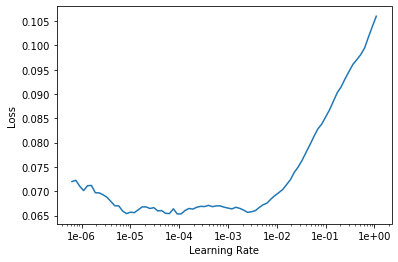

In [37]:
learn.lr_find()
learn.recorder.plot()

In [38]:
#learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
#learn.fit_one_cycle(4, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))
learn.fit_one_cycle(5, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.066473,0.061712,0.978304,0.492694,0.806117,0.539404,0.134004,0.806316,0.807533,0.538017,0.298612,0.930590,0.815400,0.530839,0.522540,0.957268,0.820755,0.523168,0.609775,0.972316,0.831511,0.508599,0.667029,0.976632,0.842033,0.493320,0.671557,0.978080,0.851189,0.479186,0.653588,0.978304,0.860186,0.465984,0.625950,05:29
1,0.066225,0.060132,0.978900,0.513295,0.807381,0.559180,0.144586,0.813992,0.807995,0.557786,0.320096,0.933826,0.812581,0.550876,0.536315,0.959332,0.819055,0.543704,0.622834,0.972928,0.830580,0.529064,0.672760,0.977353,0.843751,0.512480,0.680403,0.978764,0.854704,0.498103,0.666462,0.978900,0.863672,0.484377,0.640683,05:31
2,0.061896,0.058349,0.979596,0.550143,0.823431,0.565722,0.155086,0.833630,0.824523,0.564336,0.342182,0.940368,0.828667,0.559578,0.562687,0.962817,0.833426,0.552646,0.643234,0.974709,0.844612,0.539958,0.688058,0.978565,0.856093,0.527700,0.695950,0.979562,0.865836,0.512368,0.678732,0.979596,0.875409,0.500436,0.650346,05:45
3,0.059361,0.056710,0.980371,0.551622,0.813702,0.603743,0.153230,0.834548,0.814409,0.602618,0.340121,0.939107,0.819515,0.597442,0.560987,0.961679,0.824594,0.589900,0.642205,0.974389,0.834632,0.575957,0.694788,0.978377,0.844195,0.561648,0.703887,0.979924,0.852959,0.547740,0.696775,0.980371,0.861241,0.534720,0.677160,05:24
4,0.057604,0.056424,0.980509,0.557502,0.820377,0.600821,0.155309,0.837054,0.820917,0.599737,0.345639,0.941302,0.823201,0.594342,0.567946,0.963057,0.828116,0.587591,0.648656,0.974972,0.842352,0.571679,0.698537,0.978751,0.851737,0.557923,0.706586,0.980088,0.860763,0.544533,0.696476,0.980509,0.869042,0.530301,0.677046,05:29


### Results:

### no prep:
    after 5 epochs: learn.fit_one_cycle(5, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7))
    first: 4	0.076008	0.073660	0.975848	0.416783	0.788304	0.455926	0.122637
        last:                                       0.975848	0.843493	0.391170	0.523296	20:10

In [39]:
learn.save('third_prep')

In [40]:
learn.load('third_prep')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (14016 items)
x: TextList
xxbos commission community com proposal < legalact > parliament council recognition navigability licence inland memorandum context people commission attach importance simplify community law clearer citizen opportunity chance use aim provision time instrument research work instrument rule reason codification rule community law transparent < date > commission instruct staff act amendment stress requirement department endeavour interval text community rule conclusion presidency council stress importance codification certainty law matter time codification compliance community procedure change substance instrument codification parliament council commission agreement date < date > procedure adoption codification instrument purpose proposal codification < legalact > < date > recognition navigability licence inland < legalact > act incorporate proposal content act hence bring amendment require codification exercise 

In [41]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


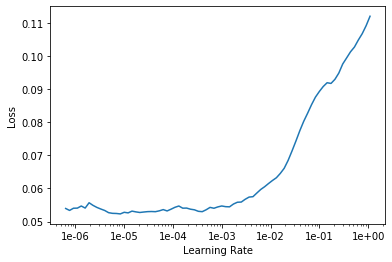

In [42]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
#learn.fit_one_cycle(15, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7)) ## too much??? but in the end it comes in nicely ..
learn.fit_one_cycle(20, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7)) ## too much??? but in the end it comes in nicely ..
#learn.fit_one_cycle(15, slice(7e-3/(2.6**4),7e-3), moms=(0.8,0.7)) ## works well
#learn.fit_one_cycle(2, slice(3e-4/(2.6**4),3e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.056615,0.056321,0.980491,0.545768,0.819984,0.600994,0.150916,0.832022,0.821036,0.599270,0.342015,0.940502,0.825866,0.594872,0.565097,0.962905,0.832368,0.588678,0.647697,0.975074,0.841145,0.573765,0.698847,0.978896,0.853640,0.557662,0.707765,0.980221,0.863778,0.541999,0.697810,0.980491,0.872183,0.527490,0.676403,06:08
1,0.054981,0.056321,0.980556,0.555936,0.818246,0.604319,0.151859,0.839874,0.818829,0.602710,0.340525,0.942371,0.824506,0.597656,0.569049,0.963655,0.829405,0.591479,0.650463,0.975448,0.842348,0.573387,0.700827,0.978954,0.851730,0.560940,0.708831,0.980321,0.860461,0.547755,0.699458,0.980556,0.868880,0.533639,0.677459,06:15
2,0.056101,0.056163,0.980665,0.577936,0.813971,0.613706,0.159103,0.847997,0.814573,0.612105,0.357503,0.943690,0.819206,0.607431,0.576856,0.963845,0.824837,0.600920,0.652935,0.975329,0.834014,0.586747,0.702253,0.978941,0.845429,0.570058,0.711265,0.980312,0.854782,0.558472,0.702869,0.980665,0.862364,0.546286,0.684559,06:19
3,0.055793,0.056047,0.980650,0.554459,0.815314,0.611639,0.153260,0.838818,0.816160,0.610423,0.350060,0.942258,0.819503,0.605252,0.571050,0.963659,0.824851,0.599270,0.651050,0.975354,0.835893,0.586849,0.701861,0.979120,0.843800,0.573276,0.711681,0.980443,0.855499,0.558572,0.703369,0.980650,0.865466,0.546182,0.682484,06:01
4,0.054577,0.055749,0.980821,0.566866,0.818005,0.614673,0.157283,0.844401,0.818833,0.613469,0.362315,0.943665,0.822831,0.608882,0.579458,0.964212,0.827066,0.602236,0.655734,0.975651,0.838011,0.589438,0.703561,0.979168,0.848297,0.574708,0.710365,0.980572,0.858256,0.560717,0.703044,0.980821,0.864859,0.546644,0.683304,06:16
5,0.053075,0.055900,0.981030,0.578751,0.820012,0.619078,0.160441,0.850511,0.820549,0.618067,0.362483,0.946117,0.824859,0.613179,0.585187,0.965213,0.829311,0.606397,0.660267,0.976095,0.838053,0.593997,0.706857,0.979310,0.845178,0.580137,0.712361,0.980649,0.857332,0.565196,0.704797,0.981030,0.865496,0.551742,0.687337,06:12
6,0.053156,0.054745,0.981155,0.571037,0.817899,0.626229,0.161307,0.846972,0.818634,0.625225,0.364545,0.945072,0.821838,0.620837,0.585112,0.965114,0.826474,0.614767,0.662223,0.976070,0.835049,0.600872,0.710984,0.979548,0.844393,0.588891,0.719347,0.980860,0.859775,0.574767,0.711254,0.981155,0.869620,0.561702,0.693327,05:58
7,0.053950,0.055187,0.981256,0.585645,0.825227,0.621427,0.162039,0.855543,0.826190,0.620471,0.374090,0.947721,0.829829,0.616095,0.593932,0.966066,0.834470,0.609603,0.665991,0.976406,0.844190,0.596762,0.711334,0.979695,0.852395,0.583183,0.719954,0.980817,0.859496,0.570654,0.709846,0.981256,0.867125,0.558541,0.694925,06:18
8,0.051967,0.054805,0.981325,0.557842,0.817333,0.632732,0.154369,0.843959,0.818360,0.631491,0.358310,0.945620,0.821921,0.625561,0.588030,0.965408,0.827351,0.618462,0.664396,0.976190,0.838766,0.603552,0.710331,0.979562,0.848795,0.591042,0.718539,0.980930,0.858244,0.578760,0.712530,0.981325,0.864644,0.565457,0.694883,06:09
9,0.049437,0.055011,0.981526,0.608553,0.821356,0.634508,0.168229,0.867898,0.822546,0.633421,0.387070,0.951851,0.826588,0.628713,0.608491,0.967917,0.830176,0.623189,0.675328,0.977298,0.837927,0.609925,0.717210,0.980047,0.846801,0.598673,0.721458,0.981189,0.852138,0.585846,0.714509,0.981526,0.859036,0.571222,0.699731,06:05


In [ ]:
learn.save('final_prep')

In [79]:
learn.load('final_prep')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (14016 items)
x: TextList
xxbos commission community com proposal < legalact > parliament council recognition navigability licence inland memorandum context people commission attach importance simplify community law clearer citizen opportunity chance use aim provision time instrument research work instrument rule reason codification rule community law transparent < date > commission instruct staff act amendment stress requirement department endeavour interval text community rule conclusion presidency council stress importance codification certainty law matter time codification compliance community procedure change substance instrument codification parliament council commission agreement date < date > procedure adoption codification instrument purpose proposal codification < legalact > < date > recognition navigability licence inland < legalact > act incorporate proposal content act hence bring amendment require codification exercise 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


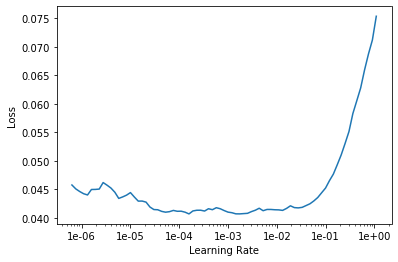

In [65]:
learn.load('final_prep')

learn.lr_find()
learn.recorder.plot()

In [98]:
learn.fit_one_cycle(7, slice(8e-4/(2.6**4),8e-4), moms=(0.8,0.7), wd=0.1) 

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.041670,0.053993,0.982288,0.659109,0.824487,0.657536,0.193493,0.888633,0.825058,0.656342,0.439155,0.957574,0.828627,0.652405,0.638202,0.970961,0.833473,0.648151,0.696180,0.978463,0.842218,0.638691,0.728037,0.980960,0.849966,0.627253,0.733253,0.981938,0.855705,0.616801,0.728015,0.982288,0.860684,0.605400,0.717743,04:31
1,0.041971,0.053902,0.982195,0.643086,0.818942,0.660710,0.185165,0.881859,0.820144,0.659971,0.422211,0.955827,0.823508,0.655997,0.630225,0.969860,0.827127,0.651030,0.690070,0.978035,0.834891,0.640443,0.726038,0.980731,0.843399,0.630826,0.733305,0.981837,0.848539,0.620089,0.729098,0.982195,0.856490,0.610772,0.718202,04:29
2,0.042706,0.053903,0.982129,0.644706,0.820103,0.656994,0.190047,0.880046,0.821446,0.655998,0.425241,0.955549,0.825192,0.652501,0.630955,0.969872,0.828949,0.647777,0.690984,0.978021,0.835856,0.637331,0.726517,0.980697,0.842740,0.628164,0.733056,0.981914,0.851090,0.618335,0.729696,0.982129,0.858527,0.607248,0.716316,04:20
3,0.041835,0.053844,0.982197,0.649892,0.822053,0.657250,0.187047,0.885305,0.822859,0.655973,0.428433,0.956606,0.827024,0.652296,0.634017,0.970463,0.831525,0.647067,0.693731,0.978347,0.838673,0.637895,0.727970,0.980785,0.844834,0.626911,0.732307,0.981950,0.853464,0.617748,0.729514,0.982197,0.859545,0.607295,0.716838,04:31
4,0.041792,0.053842,0.982217,0.644035,0.821600,0.658558,0.187418,0.884383,0.821978,0.657568,0.430115,0.956788,0.825048,0.654278,0.635267,0.970572,0.829961,0.649340,0.694743,0.978196,0.837208,0.640101,0.727009,0.980880,0.845147,0.629871,0.734242,0.981979,0.851248,0.619854,0.730185,0.982217,0.858259,0.609116,0.717259,04:15
5,0.042285,0.053759,0.982272,0.641246,0.823359,0.658178,0.184856,0.882733,0.823682,0.657088,0.425940,0.956296,0.826868,0.653273,0.633450,0.970461,0.830462,0.648129,0.694101,0.978087,0.838120,0.638483,0.725462,0.980776,0.846927,0.628537,0.732982,0.981855,0.852732,0.617795,0.727557,0.982272,0.861320,0.607168,0.717421,04:25
6,0.040562,0.053603,0.982295,0.636122,0.818715,0.665132,0.182674,0.880162,0.819316,0.664141,0.422222,0.955343,0.822315,0.660765,0.630163,0.969736,0.825671,0.655860,0.690624,0.977960,0.832278,0.645900,0.726979,0.980679,0.840598,0.635125,0.734366,0.981880,0.849201,0.624939,0.731528,0.982295,0.854715,0.614690,0.720999,04:21


In [102]:
learn.save('post_final_prep')

In [82]:
learn

RNNLearner(data=TextClasDataBunch;

Train: LabelList (14016 items)
x: TextList
xxbos commission community com proposal < legalact > parliament council recognition navigability licence inland memorandum context people commission attach importance simplify community law clearer citizen opportunity chance use aim provision time instrument research work instrument rule reason codification rule community law transparent < date > commission instruct staff act amendment stress requirement department endeavour interval text community rule conclusion presidency council stress importance codification certainty law matter time codification compliance community procedure change substance instrument codification parliament council commission agreement date < date > procedure adoption codification instrument purpose proposal codification < legalact > < date > recognition navigability licence inland < legalact > act incorporate proposal content act hence bring amendment require codification exercise 

## Evaluate the results
Based on: https://www.kaggle.com/nadjetba/text-to-meaning-with-multi-label-classification?scriptVersionId=12686831

In [99]:
#learn.load('final_prep')
# Predict on the validation dataset
y_pred, y_true =  learn.get_preds()


In [84]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

In [101]:
thresh = 0.33


print("F1 (micro)", f1_score(y_true, y_pred>thresh, average='micro'))
print("P (micro)", precision_score(y_true, y_pred>thresh, average='micro'))
print("R (micro)", recall_score(y_true, y_pred>thresh, average='micro'))

print("\nF1 (macro)", f1_score(y_true, y_pred>thresh, average='macro'))
print("P (macro)", precision_score(y_true, y_pred>thresh, average='macro'))
print("R (macro) ", recall_score(y_true, y_pred>thresh, average='macro'))


F1 (micro) 0.7385845108097051
P (micro) 0.7490744286990936
R (micro) 0.72838433368506

F1 (macro) 0.5724322962126561
P (macro) 0.6817247123992005
R (macro)  0.5349628292229112


## results:

without preprocessing -- 1st run:
    
TODO
    
with preprocessing:

TODO

    

In [36]:
f1_score(y_true, y_pred>thresh, average='macro')

0.4162056648599552

In [ ]:
y_true = y_true.numpy()
scores = y_pred.numpy()
scores.shape, y_true.shape

In [ ]:
metrics = classification_report(y_true, scores>thresh, target_names=data_clas.valid_ds.classes)
print(metrics)